<a href="https://colab.research.google.com/github/asrinivasan75/PokerBot/blob/main/PokerBot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Dependencies**

In [21]:
# First, ensure you have necessary libraries installed
!pip install tensorflow==2.8.0 keras-rl2 treys matplotlib

# Necessary imports
import random
import numpy as np
import gym
from gym import spaces
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from rl.agents.dqn import DQNAgent
from rl.memory import SequentialMemory
from rl.policy import BoltzmannQPolicy
from treys import Evaluator, Card

# **# Classes and Functions**

In [22]:

# Improved Card class with suit symbols
class PokerCard:
    SUITS = {'s': '♠', 'h': '♥', 'd': '♦', 'c': '♣'}
    RANKS = {'2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9', 'T': '10', 'J': 'J', 'Q': 'Q', 'K': 'K', 'A': 'A'}

    def __init__(self, rank, suit):
        self.rank = rank
        self.suit = suit

    def __repr__(self):
        return f"{PokerCard.RANKS[self.rank]}{PokerCard.SUITS[self.suit]}"

# Define the Deck class
class Deck:
    def __init__(self):
        ranks = '23456789TJQKA'
        suits = 'shdc'
        self.cards = [PokerCard(rank, suit) for rank in ranks for suit in suits]
        random.shuffle(self.cards)

    def deal(self):
        return self.cards.pop()

# Define the Hand class
class Hand:
    def __init__(self, cards):
        self.cards = cards

    def add_card(self, card):
        self.cards.append(card)

    def __repr__(self):
        return f"Hand: {', '.join(map(str, self.cards))}"

# Define the Poker environment
class PokerEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self):
        super(PokerEnv, self).__init__()

        # Define action and observation space
        self.action_space = spaces.Discrete(3)  # Actions: Fold, Call, Raise
        self.observation_space = spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32)

        self.evaluator = Evaluator()
        self.reset()

    def reset(self):
        self.deck = Deck()
        self.player_hand = Hand([self.deck.deal(), self.deck.deal()])
        self.opponent_hand = Hand([self.deck.deal(), self.deck.deal()])
        self.community_cards = [self.deck.deal() for _ in range(5)]  # Deal 5 community cards

        self.state = np.array([self.evaluate_hand(self.player_hand)])
        self.done = False
        return self.state

    def convert_to_treys(self, hand):
        """
        Converts PokerCard objects to the treys format (used by Evaluator).
        """
        return [Card.new(f"{card.rank}{card.suit}") for card in hand.cards]

    def evaluate_hand(self, hand):
        treys_hand = self.convert_to_treys(hand)
        treys_community = self.convert_to_treys(Hand(self.community_cards))

        # Evaluate the best possible hand with community cards
        rank = self.evaluator.evaluate(treys_community, treys_hand)
        normalized_rank = 1 - (rank / 7462)  # Normalize rank between 0 and 1
        return normalized_rank

    def step(self, action):
        reward = 0
        if action == 0:  # Fold
            reward = -0.5  # Penalty for folding
            self.done = True
        elif action == 1:  # Call
            if self.compare_hands(self.player_hand, self.opponent_hand):
                reward = 1  # Reward for winning
            else:
                reward = -1  # Penalty for losing
            self.done = True
        elif action == 2:  # Raise
            if self.compare_hands(self.player_hand, self.opponent_hand):
                reward = 1.5  # Higher reward for raising and winning
            else:
                reward = -1.5  # Higher penalty for losing after raising
            self.done = True

        next_state = self.state
        return next_state, reward, self.done, {}

    def compare_hands(self, player_hand, opponent_hand):
        player_strength = self.evaluate_hand(player_hand)
        opponent_strength = self.evaluate_hand(opponent_hand)
        return player_strength > opponent_strength

    def render(self, mode='human'):
        print(f"Player's Hand: {self.player_hand}")
        print(f"Opponent's Hand: {self.opponent_hand}")
        print(f"Community Cards: {', '.join(map(str, self.community_cards))}")

# Human vs Bot Interaction
def human_vs_bot(env, dqn):
    """
    Function to allow a human to play against the bot.
    """
    # Reset the environment
    state = env.reset()
    done = False

    # Display initial hands and community cards
    print("\n=== Starting New Round ===")
    env.render()

    # Human and Bot take turns until the round is done
    while not done:
        # Human's turn
        print("\nYour turn:")
        print("Actions: 0 - Fold, 1 - Call, 2 - Raise")
        human_action = int(input("Choose your action (0/1/2): "))

        # Apply human action to the game
        next_state, reward, done, _ = env.step(human_action)

        if done:
            if reward > 0:
                print("You win!")
            else:
                print("You lose!")
            break

        # Bot's turn
        print("\nBot's turn:")
        bot_action = dqn.forward(state)  # Bot chooses an action
        next_state, reward, done, _ = env.step(bot_action)
        print(f"Bot chose action: {bot_action}")

        if done:
            if reward < 0:
                print("You win!")
            else:
                print("Bot wins!")
            break

        state = next_state
        env.render()


In [41]:
# Build the model for the DQN agent
def build_model(states, actions):
    model = Sequential()
    model.add(Flatten(input_shape=(1, states)))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(actions, activation='linear'))
    return model

# Build the agent
def build_agent(model, actions):
    policy = BoltzmannQPolicy()
    memory = SequentialMemory(limit=10000, window_length=1)
    dqn = DQNAgent(model=model, memory=memory, policy=policy,
                   nb_actions=actions, nb_steps_warmup=1000,
                   target_model_update=1e-2)
    return dqn

# Instantiate the Poker environment
env = PokerEnv()

# Build and compile the DQN agent
states = env.observation_space.shape[0]
actions = env.action_space.n
model = build_model(states, actions)
dqn = build_agent(model, actions)
dqn.compile(Adam(learning_rate=1e-3), metrics=['mae'])

In [43]:

# Train the agent
dqn.fit(env, nb_steps=50000, visualize=False, verbose=1)

Training for 50000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 208s 21ms/step - reward: -0.0969
10000 episodes - episode_reward: -0.097 [-1.500, 1.500] - loss: 0.511 - mae: 0.573 - mean_q: 0.067

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 224s 22ms/step - reward: -0.1047
10000 episodes - episode_reward: -0.105 [-1.500, 1.500] - loss: 0.511 - mae: 0.571 - mean_q: 0.077

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 229s 23ms/step - reward: -0.1311
10000 episodes - episode_reward: -0.131 [-1.500, 1.500] - loss: 0.502 - mae: 0.574 - mean_q: 0.043

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 232s 23ms/step - reward: -0.1082
10000 episodes - episode_reward: -0.108 [-1.500, 1.500] - loss: 0.484 - mae: 0.581 - mean_q: 0.065

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 231s 23ms/step - reward: -0.0985


In [51]:
# Modified testing function to correctly collect rewards and actions
def test_agent(dqn, env, nb_episodes=100):
    """
    Test the trained agent on multiple hands and visualize the performance.
    Collects rewards and actions during the test episodes.
    """
    history = {
        "rewards": [],
        "actions": [],
    }

    # Reset the environment and variables for each episode
    for episode in range(nb_episodes):
        state = env.reset()
        done = False
        total_reward = 0
        while not done:
            action = dqn.forward(state)  # Get action from the agent
            next_state, reward, done, _ = env.step(action)
            total_reward += reward
            history['actions'].append(action)
            state = next_state
        history['rewards'].append(total_reward)

    return history

# Function to plot the cumulative rewards
def plot_cumulative_rewards(rewards):
    cumulative_rewards = np.cumsum(rewards)
    plt.figure(figsize=(10, 6))
    plt.plot(cumulative_rewards)
    plt.title("Cumulative Rewards over Test Hands")
    plt.xlabel("Hand Number")
    plt.ylabel("Cumulative Reward")
    plt.grid(True)
    plt.show()

# Function to plot action distribution
def plot_action_distribution(actions):
    action_labels = ['Fold', 'Call', 'Raise']
    action_counts = [actions.count(0), actions.count(1), actions.count(2)]

    plt.figure(figsize=(8, 6))
    plt.bar(action_labels, action_counts, color=['red', 'blue', 'green'])
    plt.title("Action Distribution (Fold, Call, Raise)")
    plt.ylabel("Count")
    plt.show()



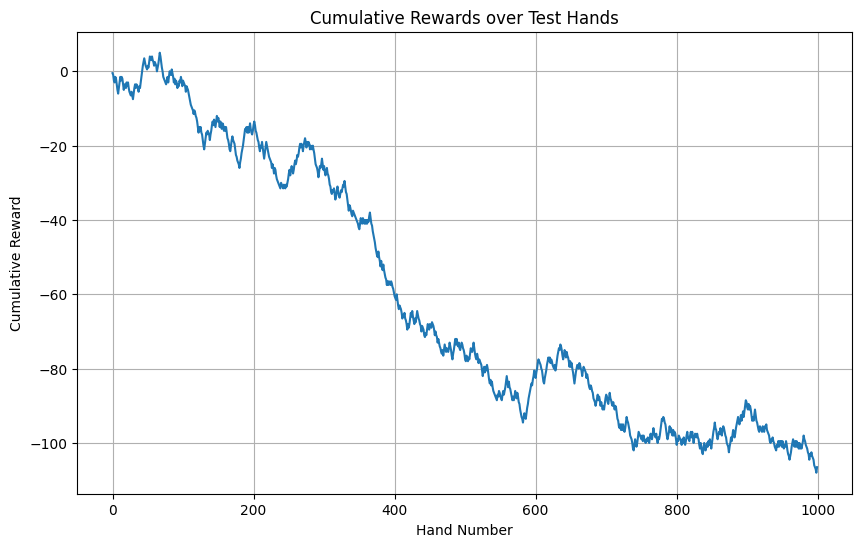

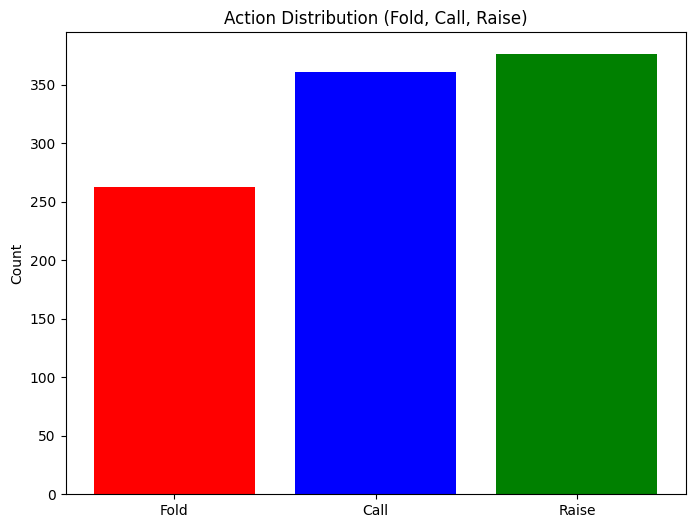

In [52]:
# Test the agent on 100 hands and collect the results
history = test_agent(dqn, env, nb_episodes=1000)

# Plot cumulative rewards
plot_cumulative_rewards(history['rewards'])

# Plot action distribution
plot_action_distribution(history['actions'])

In [40]:
human_vs_bot(env, dqn)


=== Starting New Round ===
Player's Hand: Hand: Q♥, 7♣
Opponent's Hand: Hand: 10♥, 10♣
Community Cards: 9♣, Q♠, Q♣, K♣, A♥

Your turn:
Actions: 0 - Fold, 1 - Call, 2 - Raise
Choose your action (0/1/2): 2
You win!
